In [14]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
from time import time

import numpy as np
import scipy as sp
import pandas as pd

from scipy.optimize import fmin_powell
from scipy import integrate
from scipy import linalg

from sklearn.preprocessing import normalize
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

np.set_printoptions(precision=4, suppress=True)

from collections import Counter
# from Levenshtein import distance as levenshtein_distance

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('axes', **{'titlesize': '16', 'labelsize': '16'})
rc('legend', **{'fontsize': '16'})
rc('figure', **{'dpi' : 200})

## Relevance vector machines

In [15]:
from sklearn.svm import SVC
import sklearn_rvm
from sklearn_rvm import EMRVC, EMRVR

In [16]:
def sample_mixture(N, pi, mu1, sigma1, mu2, sigma2):
    z = np.array( np.random.rand(N) < pi, dtype=int)
    res = np.zeros((N, 2))
    res[np.where(z == 1)] = np.random.multivariate_normal(mu1, sigma1, np.sum(z))
    res[np.where(z == 0)] = np.random.multivariate_normal(mu2, sigma2, N-np.sum(z))
    return z, res

def sample_two_classes(mu1, sigma1, mu2, sigma2, pi=0.5, N=200, Ntest=None):
    z, x = sample_mixture(N, pi, mu1, sigma1, mu2, sigma2)
    if Ntest is None:
        return z, x
    else:
        test_z, test_x = sample_mixture(Ntest, pi, mu1, sigma1, mu2, sigma2)
        return z, x, test_z, test_x

def plot_points(ax, x, z, mus=None, mu1=None, mu2=None, sigmas=None, points_alpha=1.0, colors=['r', 'b', 'g', 'magenta', 'grey', 'purple', 'darkgreen']):
    print(set(z))
    for i in set(z):
        ax.scatter(x[np.where(z==i), 0], x[np.where(z==i), 1], marker='.', color=colors[i % 7], alpha=points_alpha)
        if sigmas is not None:
            plot_ellipse(ax, mus[i], sigmas[i], colors[i % 7])
    if mus is not None:
        for i in range(mus.shape[0]):
            ax.scatter([mus[i, 0]], [mus[i, 1]], marker='*', s=200, color=colors[i % 7])
    if mu1 is not None:
        for i in range(mu1.shape[0]):
            ax.scatter([mu1[i, 0]], [mu1[i, 1]], marker='*', s=200, color=colors[0])
    if mu2 is not None:
        for i in range(mu2.shape[0]):
            ax.scatter([mu2[i, 0]], [mu2[i, 1]], marker='*', s=200, color=colors[1])

from matplotlib import colors
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})

def plot_ellipse(ax, mu, sigma, color):
    v, w = sp.linalg.eigh(sigma)
    u = w[0] / sp.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi
    ell = mpl.patches.Ellipse(mu, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='black', linewidth=2)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.2)
    ax.add_artist(ell)
    ax.scatter(mu[0], mu[1], marker='+', color=color, s=100)

def get_meshgrid(nx=200, ny=200):
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    return np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))

def plot_colormesh(ax, model):
    xx, yy = get_meshgrid()
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap,
                   norm=colors.Normalize(0., 1.), zorder=0)
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')

def plot_colormesh_svm(ax, model):
    xx, yy = get_meshgrid()
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=cmap,
                   norm=colors.Normalize(0., 1.), zorder=0)
    ax.contour(xx, yy, Z, [-1, 0, 1], linewidths=2., colors='white', linestyles=['--', '-', '--'])

def plot_svm_decision(ax, model, xx, yy):
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contour(xx, yy, Z, [0], linewidths=.5, colors='black', linestyles=['-'])

def plot_svm_decisions(ax, models):
    xx, yy = get_meshgrid()
    for model in models:
        plot_svm_decision(ax, model, xx, yy)
        
def sample_rings(rad_inner, rad_outer, rad_inner2, rad_outer2, pi=0.5, N=200, Ntest=None):
    z = np.array( np.random.rand(N) < pi, dtype=int)
    rs = ( rad_inner + (rad_inner - rad_outer) * np.random.rand(np.sum(z)) )
    thetas = 2 * np.pi * np.random.rand(np.sum(z))
    rs2 = ( rad_inner2 + (rad_inner2 - rad_outer2) * np.random.rand(N - np.sum(z)) )
    thetas2 = 2 * np.pi * np.random.rand(N - np.sum(z))
    
    res = np.zeros((N, 2))
    res[np.where(z == 1)] = np.array([ rs * np.cos(thetas), rs * np.sin(thetas) ]).T
    res[np.where(z == 0)] = np.array([ rs2 * np.cos(thetas2), rs2 * np.sin(thetas2) ]).T
    return z, res

def sample_mixture(N, pi, mu1, sigma1, mu2, sigma2):
    z = np.array( np.random.rand(N) < pi, dtype=int)
    res = np.zeros((N, 2))
    res[np.where(z == 1)] = np.random.multivariate_normal(mu1, sigma1, np.sum(z))
    res[np.where(z == 0)] = np.random.multivariate_normal(mu2, sigma2, N-np.sum(z))
    return z, res

def sample_mixtures(mu0=np.array([ [-1,-1], [1,1] ]), sigma0=2, k=5, pi=0.5, df=4, N=200, Ntest=None):
    z = np.array( np.random.rand(N) < pi, dtype=int)
    res = np.zeros((N, 2))
    mus, sigmas = [], []
    for i, n in zip(range(2), [N-np.sum(z), np.sum(z)]):
        mus.append( np.random.multivariate_normal(mu0[i], sigma0 * np.identity(2), k) )
        sigmas.append( sp.stats.invwishart.rvs(df, np.identity(2), size=k) )
        mixture_ind = np.random.randint(k, size=n)
        cur_res = np.zeros((n, 2))
        for j in range(k):
            cur_indices = np.where(mixture_ind == j)[0]
            cur_res[cur_indices] = np.random.multivariate_normal(mus[-1][j], sigmas[-1][j], len(cur_indices))
        res[np.where(z == i)] = cur_res
    return z, res, mus, sigmas

def sample_oneclass_mixture(mu0=np.array([0, 0]), sigma0=2, k=5, pi=None, df=4, N=200, Ntest=None):
    mus = np.random.multivariate_normal(mu0, sigma0 * np.identity(2), k)
    sigmas = sp.stats.invwishart.rvs(df, np.identity(2), size=k)
    mixture_ind = np.random.randint(k, size=N)
    res = np.zeros((N, 2))
    for j in range(k):
        cur_indices = np.where(mixture_ind == j)[0]
        res[cur_indices] = np.random.multivariate_normal(mus[j], sigmas[j], len(cur_indices))
    return np.eye(k)[mixture_ind], res, mus, sigmas


In [17]:
## Оверфиттинг
## Исходная функция
orig = lambda x : np.sin(2*x)

## X-координаты точек данных
xd = np.array([-3, -2, -1, -0.5, 0, 0.5, 1, 1.5, 2.5, 3, 4]) / 2
num_points = len(xd)

## X-координаты точек данных
xd_large = np.arange(-1.5, 2, 0.05)
num_points_l = len(xd_large)

## Данные
data = orig(xd) + np.random.normal(0, .25, num_points)
data_dict = { x : val for x, val in zip(xd, data) }
data_large = orig(xd_large) + np.random.normal(0, .25, num_points_l)
data_large_dict = { x : val for x, val in zip(xd_large, data_large) }

## Для рисования
xs = np.arange(xd[0]-1.5, xd[-1]+1.5, 0.01)

## Обучаем модель с регуляризацией
@ignore_warnings(category=ConvergenceWarning)
def train_model(xs, ys, alpha=0, use_lasso=False):
    if alpha == 0:
        return linear_model.LinearRegression(fit_intercept=True).fit( xs, ys )
    else:
        if use_lasso:
            return linear_model.Lasso(alpha=alpha, fit_intercept=True).fit( xs, ys )
        else:
            return linear_model.Ridge(alpha=alpha, fit_intercept=True).fit( xs, ys )

[ 1.4173  0.0953 -0.5223]
[  1.0022   4.7374   7.5973 -15.8582 -19.2631  19.2852  14.6303 -10.4482
  -3.3998   2.0472]


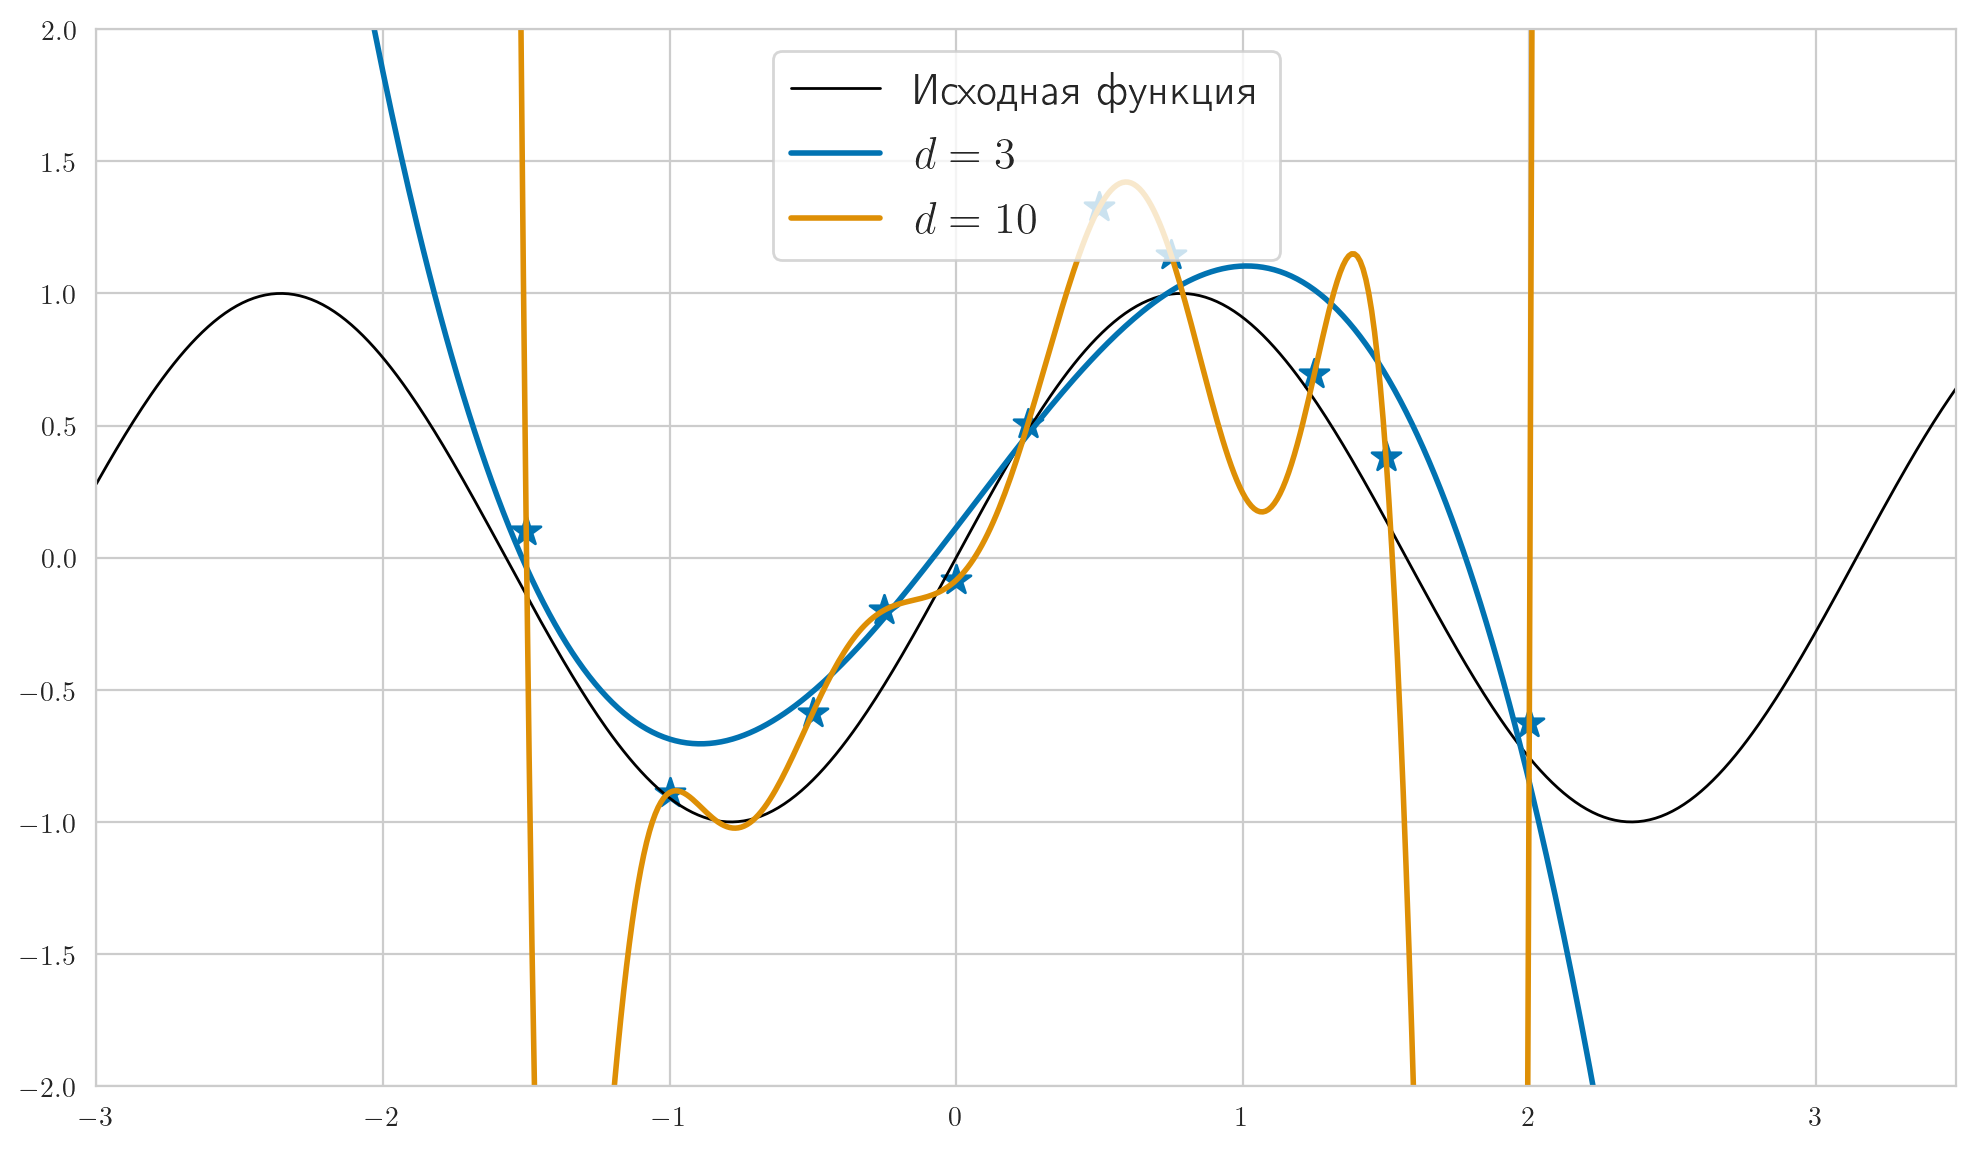

In [18]:
## Выделение полиномиальных признаков
xs_d = np.vstack([xs ** i for i in range(1, num_points+1)]).transpose()
xd_d = np.vstack([xd ** i for i in range(1, num_points+1)]).transpose()

## Какие степени многочлена будем обучать и рисовать
set_of_powers = [ 3, 10 ]

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
ax.scatter(xd, data, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")

for d in set_of_powers:
    if d == 0:
        print(np.mean(data))
        ax.hlines(np.mean(data), xmin=xs[0], xmax=xs[-1], label="$d=0$", linestyle="dashed")
    else:
        cur_model = train_model( xd_d[:, :d], data )
        print(cur_model.coef_)
        ax.plot(xs, cur_model.predict( xs_d[:, :d] ), linewidth=2, label="$d=%d$" % d)

ax.legend(loc="upper center", fontsize=legend_fontsize)

plt.show()

In [20]:
xx.shape

(11,)

In [19]:
xx, yy, dd = xd, data, data_dict
# xx, yy, dd = xd_large, data_large, data_large_dict
model = EMRVR(kernel="rbf", verbose=True)
model.fit(xx.reshape(-1, 1), yy)

Iteration: 0
Alpha: [0.0792 0.0168 0.006  0.0025 0.507  0.0033 0.1068 0.0043 0.0619 0.0038
 0.0057 0.806 ]
Beta: 24.554312036757825
Gamma: [0.8097 0.8679 0.8948 0.6079 0.41   0.4575 0.4398 0.4445 0.5579 0.5954
 0.671  0.8625]
mu: [ -3.1975   7.1801 -12.2129  15.7424  -0.8993 -11.7495  -2.0298  10.1286
   3.0033 -12.4668  10.8061  -1.0344]
Relevance Vectors: 11

Iteration: 1
Alpha: [   3.249     0.098     0.0296    0.0313 1880.8631    0.0457    6.3157
    0.1151    1.315     5.6347    2.5541    4.9493]
Beta: 20.432540969263144
Gamma: [0.6082 0.8857 0.8762 0.8955 0.0047 0.8585 0.0277 0.835  0.0954 0.8602
 0.8275 0.1053]
mu: [-0.4327  3.0062 -5.4442  5.3493  0.0016 -4.3354 -0.0663  2.6934  0.2694
  0.3907 -0.5692 -0.1459]
Relevance Vectors: 11

Iteration: 2
Alpha: [      5.3026       0.3776       0.1513       0.275  5210838.4437
       0.2628     152.0876       0.3485       1.4789      35.1464
      66.0161       3.4914]
Beta: 20.50461920497781
Gamma: [0.2337 0.8867 0.8616 0.8064 0.     0

Iteration: 38
Alpha: [78.8109  2.2863  0.9149  3.3501]
Beta: 19.342863283337227
Gamma: [0.3516 0.9733 0.9891 0.9471]
mu: [ 0.0668 -0.6524  1.0397 -0.5317]
Relevance Vectors: 4

Iteration: 39
Alpha: [79.9927  2.2907  0.9156  3.3529]
Beta: 19.322043613862398
Gamma: [0.3469 0.9732 0.9891 0.947 ]
mu: [ 0.0659 -0.6518  1.0394 -0.5315]
Relevance Vectors: 4

Iteration: 40
Alpha: [80.9104  2.2941  0.916   3.355 ]
Beta: 19.306215481698434
Gamma: [0.3433 0.9732 0.9891 0.9469]
mu: [ 0.0651 -0.6513  1.0391 -0.5313]
Relevance Vectors: 4

Iteration: 41
Alpha: [81.6232  2.2966  0.9164  3.3566]
Beta: 19.294119791250704
Gamma: [0.3405 0.9732 0.9891 0.9469]
mu: [ 0.0646 -0.651   1.0389 -0.5311]
Relevance Vectors: 4

Iteration: 42
Alpha: [82.177   2.2986  0.9167  3.3578]
Beta: 19.284839745469185
Gamma: [0.3384 0.9732 0.989  0.9468]
mu: [ 0.0642 -0.6507  1.0387 -0.531 ]
Relevance Vectors: 4

Iteration: 43
Alpha: [82.6074  2.3001  0.9169  3.3588]
Beta: 19.277698244869942
Gamma: [0.3368 0.9732 0.989  0.9468

In [21]:
predicted_y, predicted_std = model.predict(xs.reshape(-1, 1), return_std=True)

4 релевантных векторов


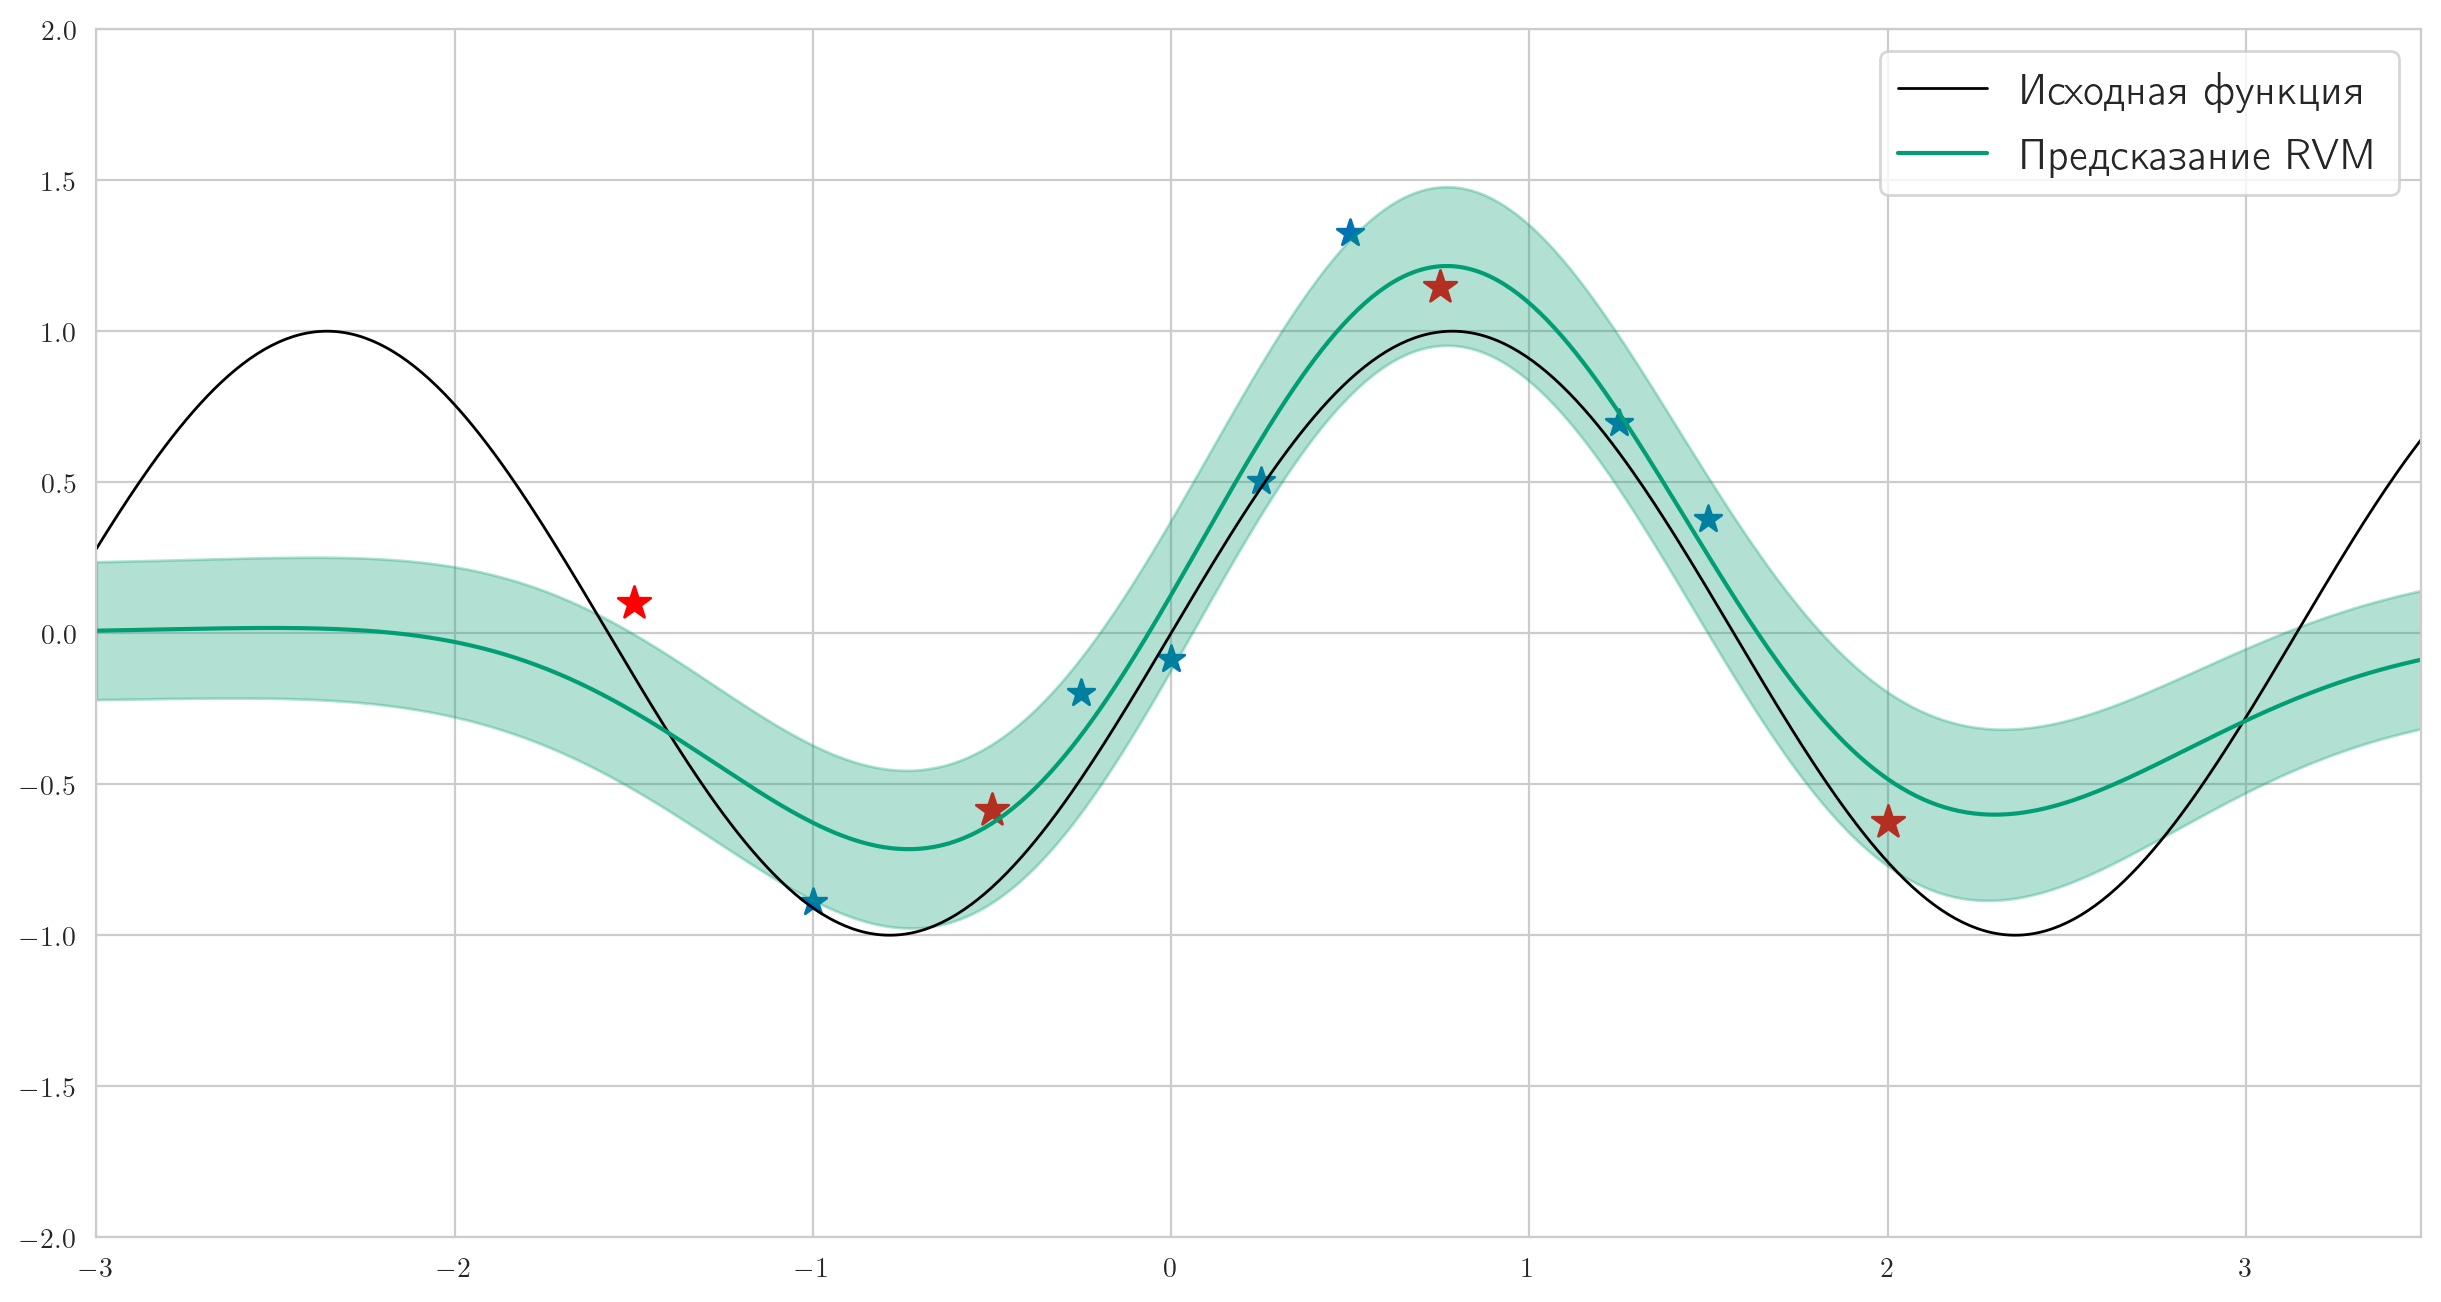

In [22]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
print("%d релевантных векторов" % model.relevance_vectors_.shape[0])
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
ax.scatter(xx, yy, marker='*', s=100)
ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")
ax.scatter( [ x[0] for x in model.relevance_vectors_], [dd[x[0]] for x in model.relevance_vectors_ ], color='red', marker='*', s=150 )
ax.plot( xs, predicted_y, color=palette[2], label="Предсказание RVM" )
ax.fill_between(xs, predicted_y-predicted_std, predicted_y+predicted_std, color=palette[2], alpha=.3)
ax.legend()
# plot_points(ax, x, z, mu1=mus[1], mu2=mus[0])
# plot_colormesh_svm(ax, model)
# plt.savefig("svm-rvm1.pdf", bbox_inches="tight")
plt.show()

4 релевантных векторов


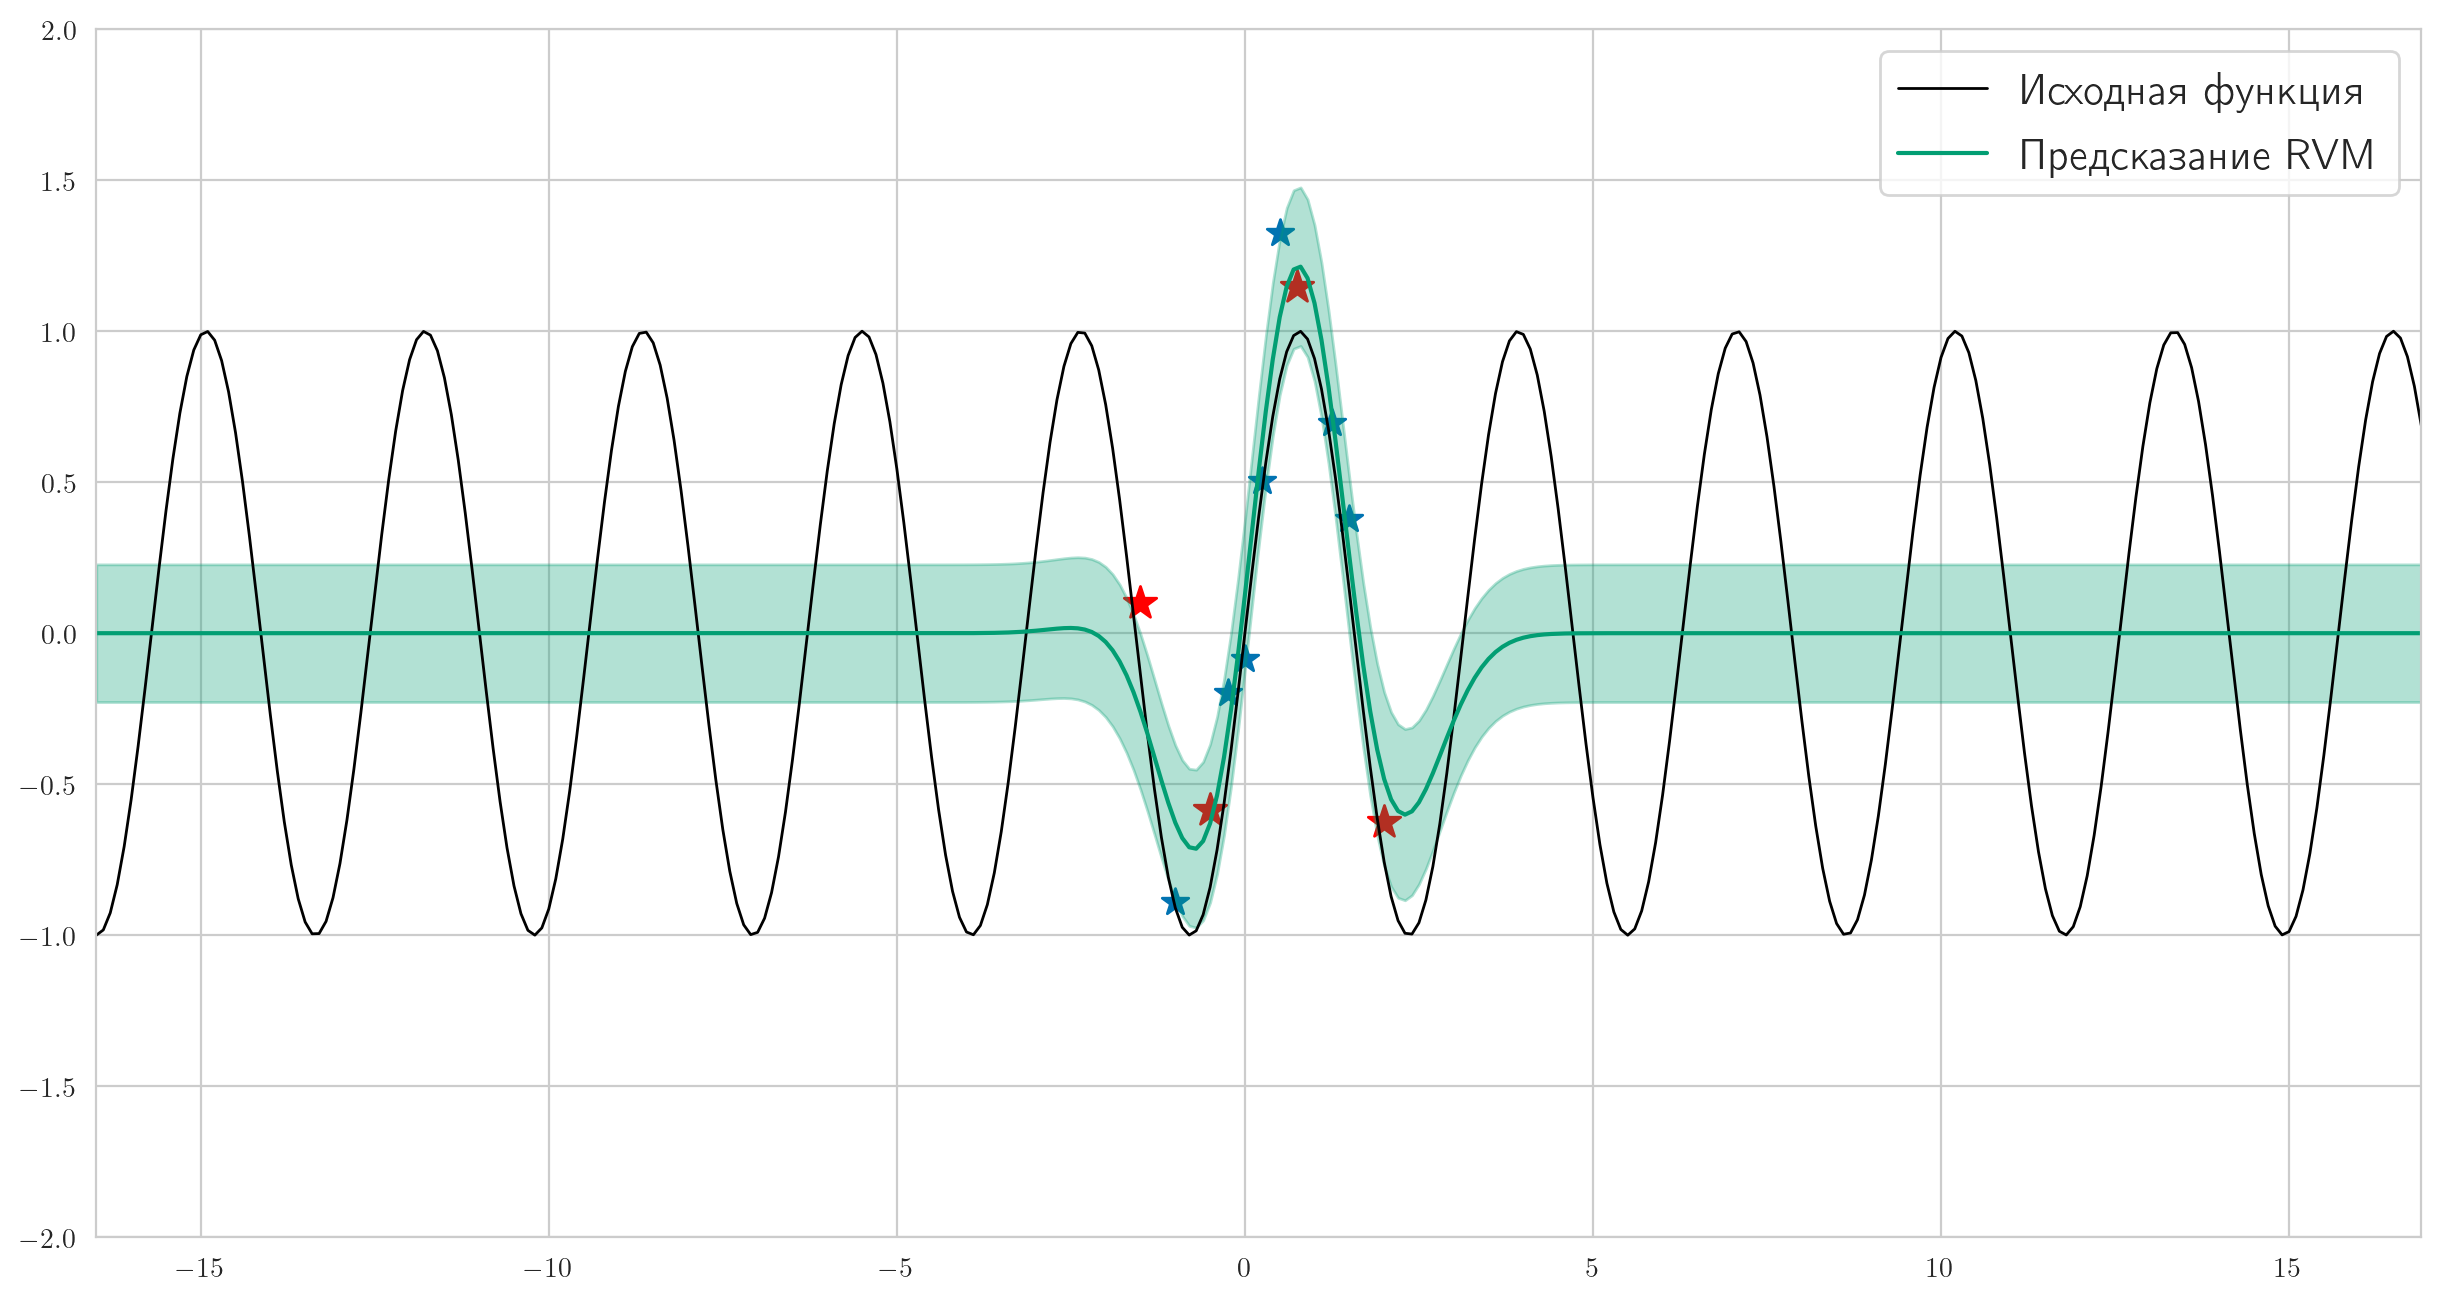

In [23]:
xs2 = np.arange(xd[0]-15, xd[-1]+15, 0.1)
predicted_y2, predicted_std2 = model.predict(xs2.reshape(-1, 1), return_std=True)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
print("%d релевантных векторов" % model.relevance_vectors_.shape[0])
ax = fig.add_subplot(111)
ax.set_xlim((xs2[0], xs2[-1]))
ax.set_ylim((-2, 2))
ax.scatter(xx, yy, marker='*', s=100)
ax.plot(xs2, orig(xs2), linewidth=1, label="Исходная функция", color="black")
ax.scatter( [ x[0] for x in model.relevance_vectors_], [dd[x[0]] for x in model.relevance_vectors_ ], color='red', marker='*', s=150 )
ax.plot( xs2, predicted_y2, color=palette[2], label="Предсказание RVM" )
ax.fill_between(xs2, predicted_y2-predicted_std2, predicted_y2+predicted_std2, color=palette[2], alpha=.3)
ax.legend()
plt.show()

{0, 1}


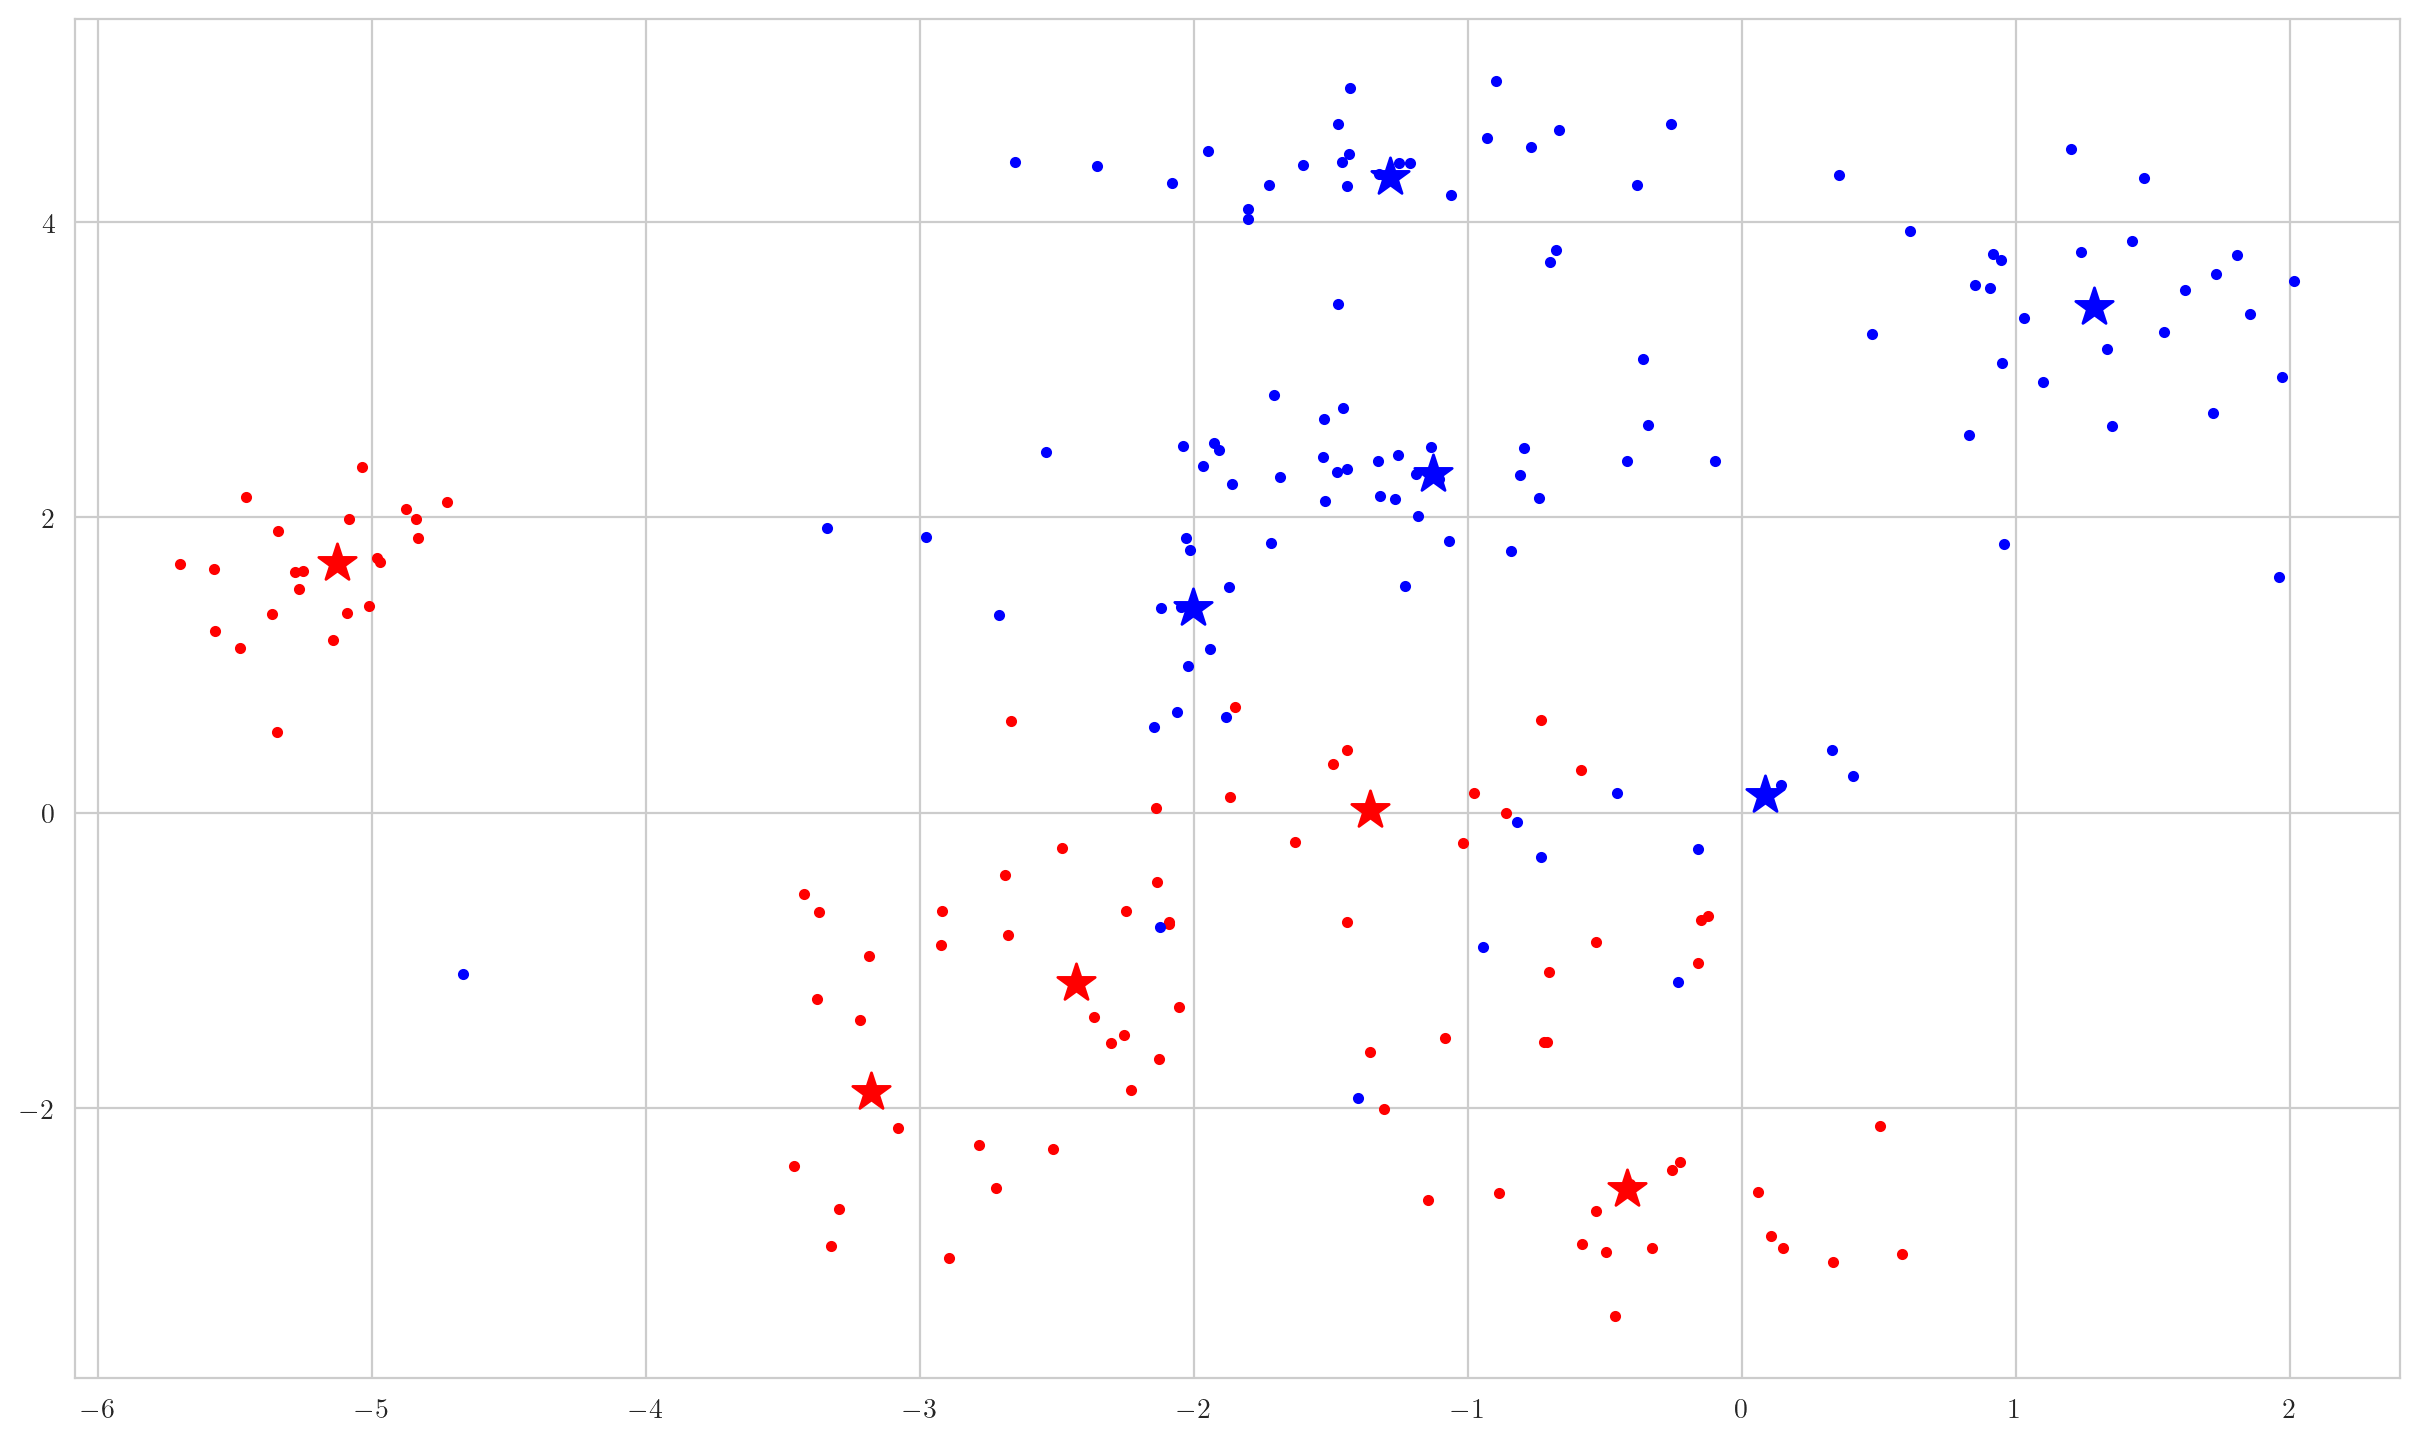

In [31]:
z, x, mus, sigmas = sample_mixtures(k=5, sigma0=5, N=200)

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
plot_points(ax, x, z, mu1=mus[0], mu2=mus[1])
plt.show()

In [32]:
model = EMRVC(kernel="rbf", n_iter_posterior=6).fit(x, z)

9 релевантных векторов
{0, 1}


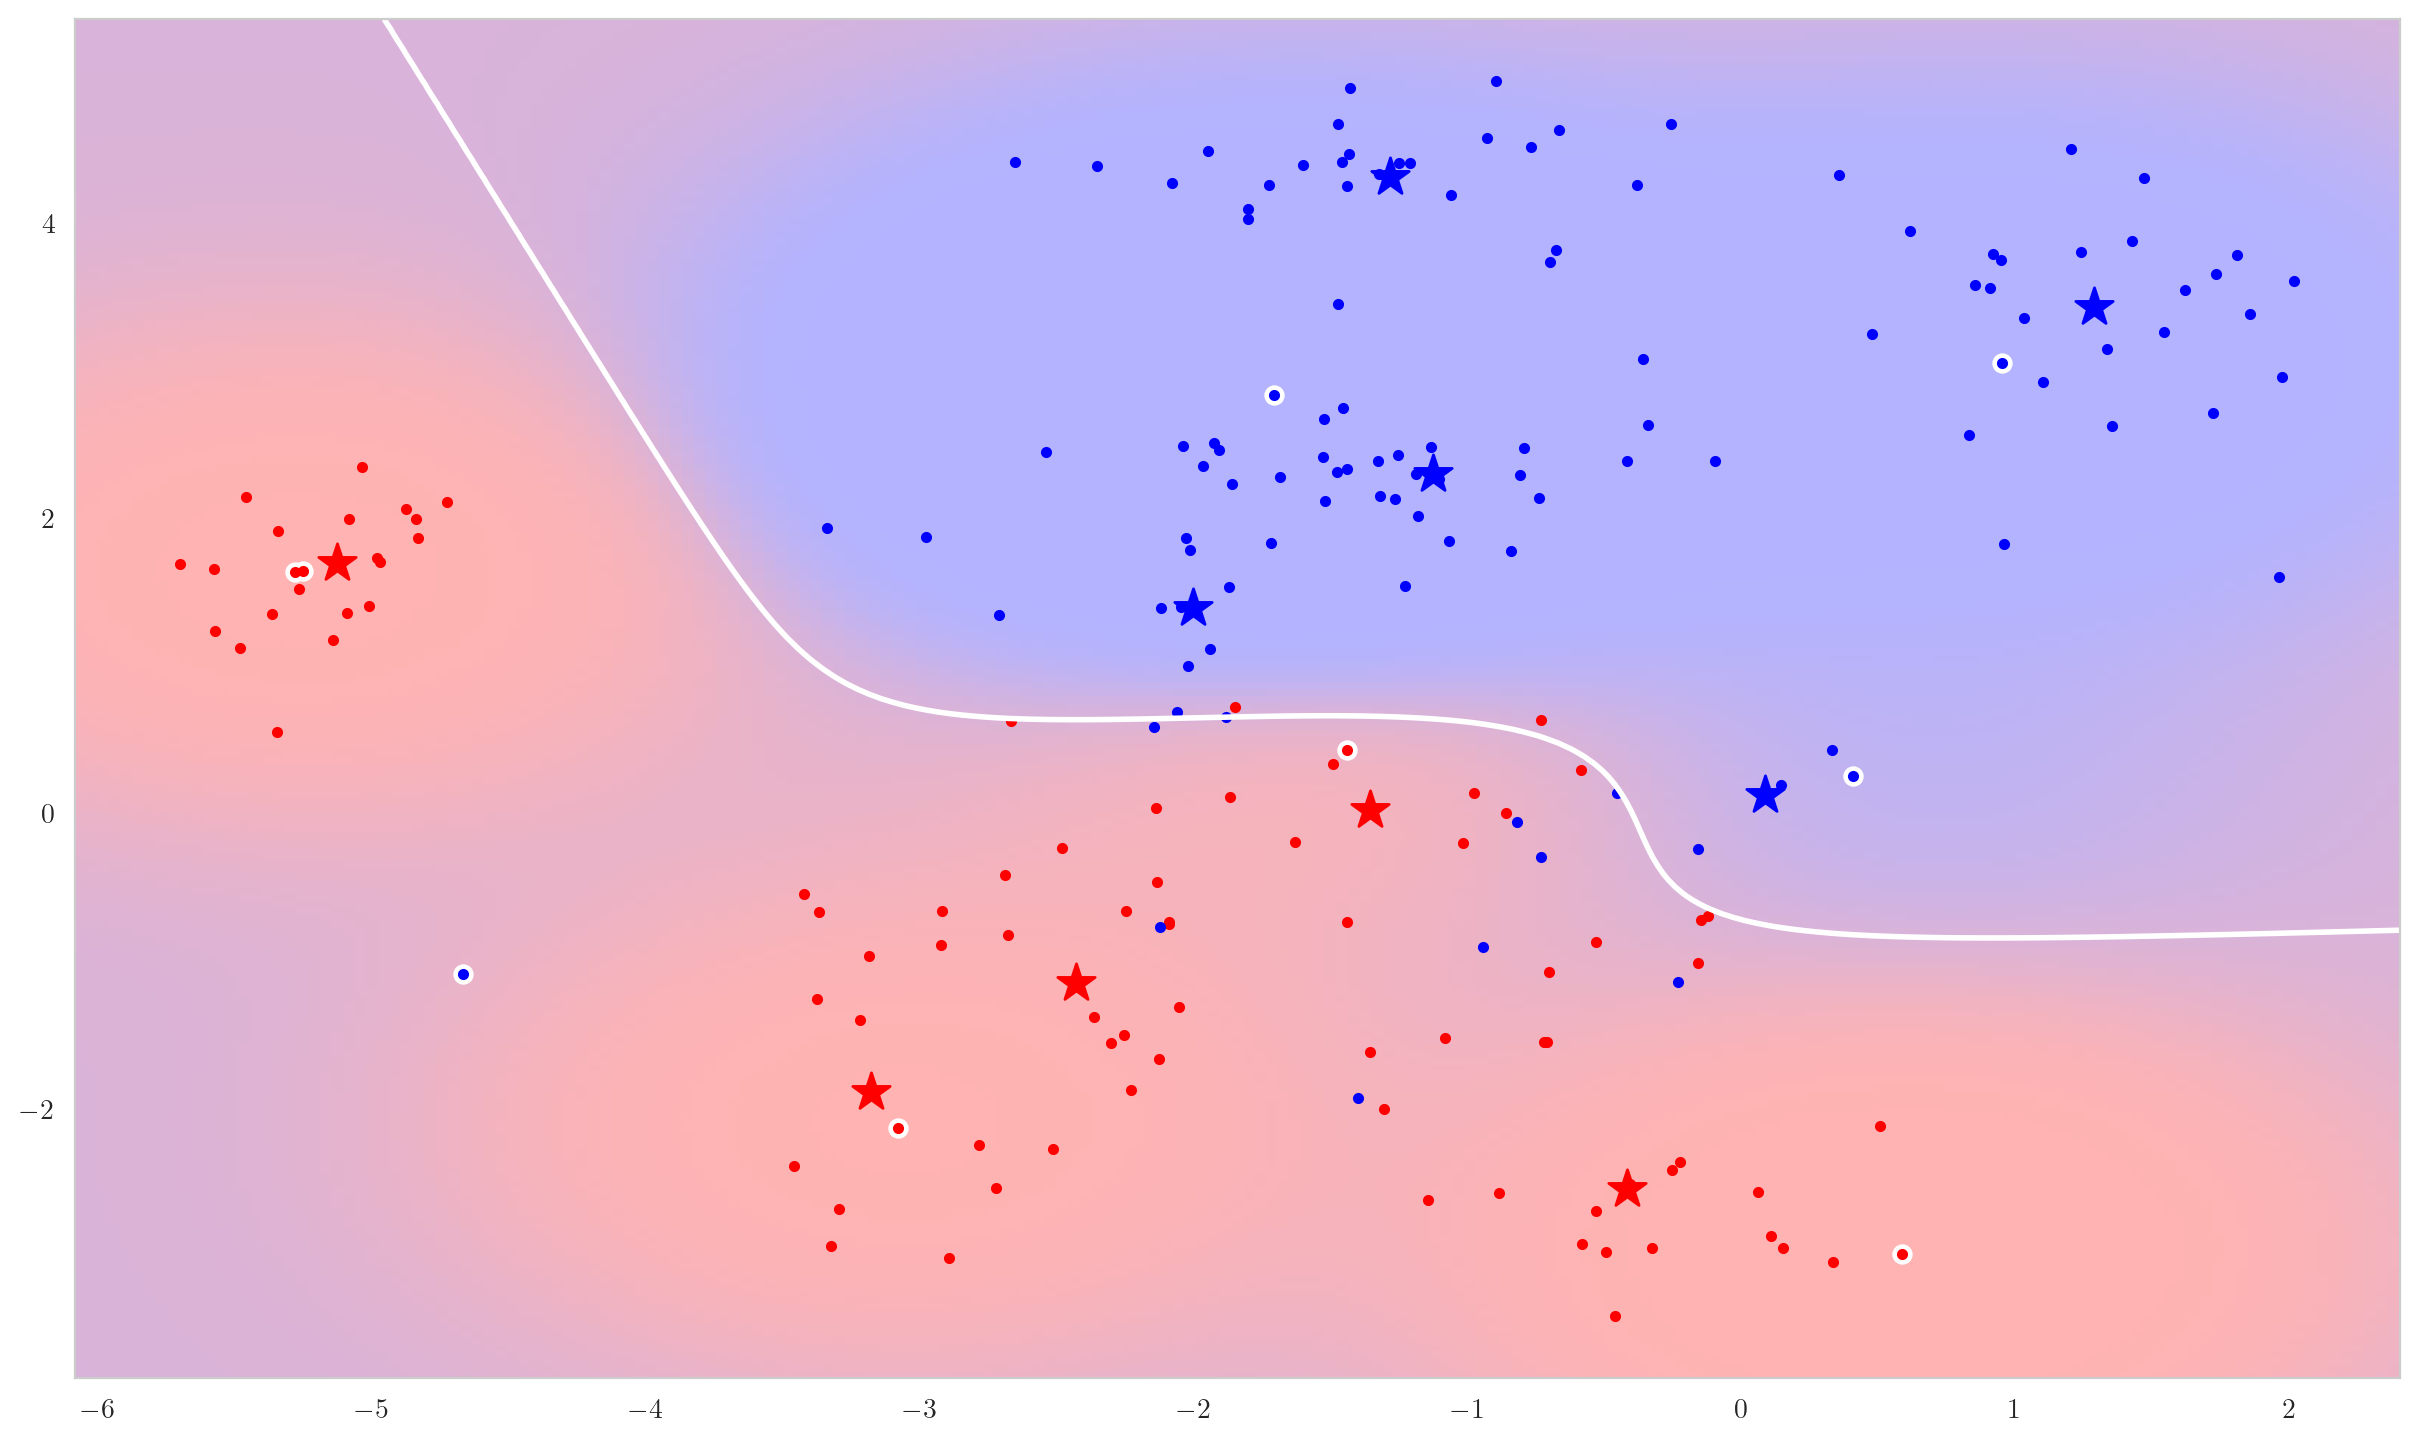

In [33]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
print("%d релевантных векторов" % model.relevance_vectors_.shape[0])
ax.scatter( model.relevance_vectors_[:, 0], model.relevance_vectors_[:, 1], color='white', s=40 )
plot_points(ax, x, z, mu1=mus[0], mu2=mus[1])
plot_colormesh(ax, model)
plt.show()

52 опорных векторов
{0, 1}


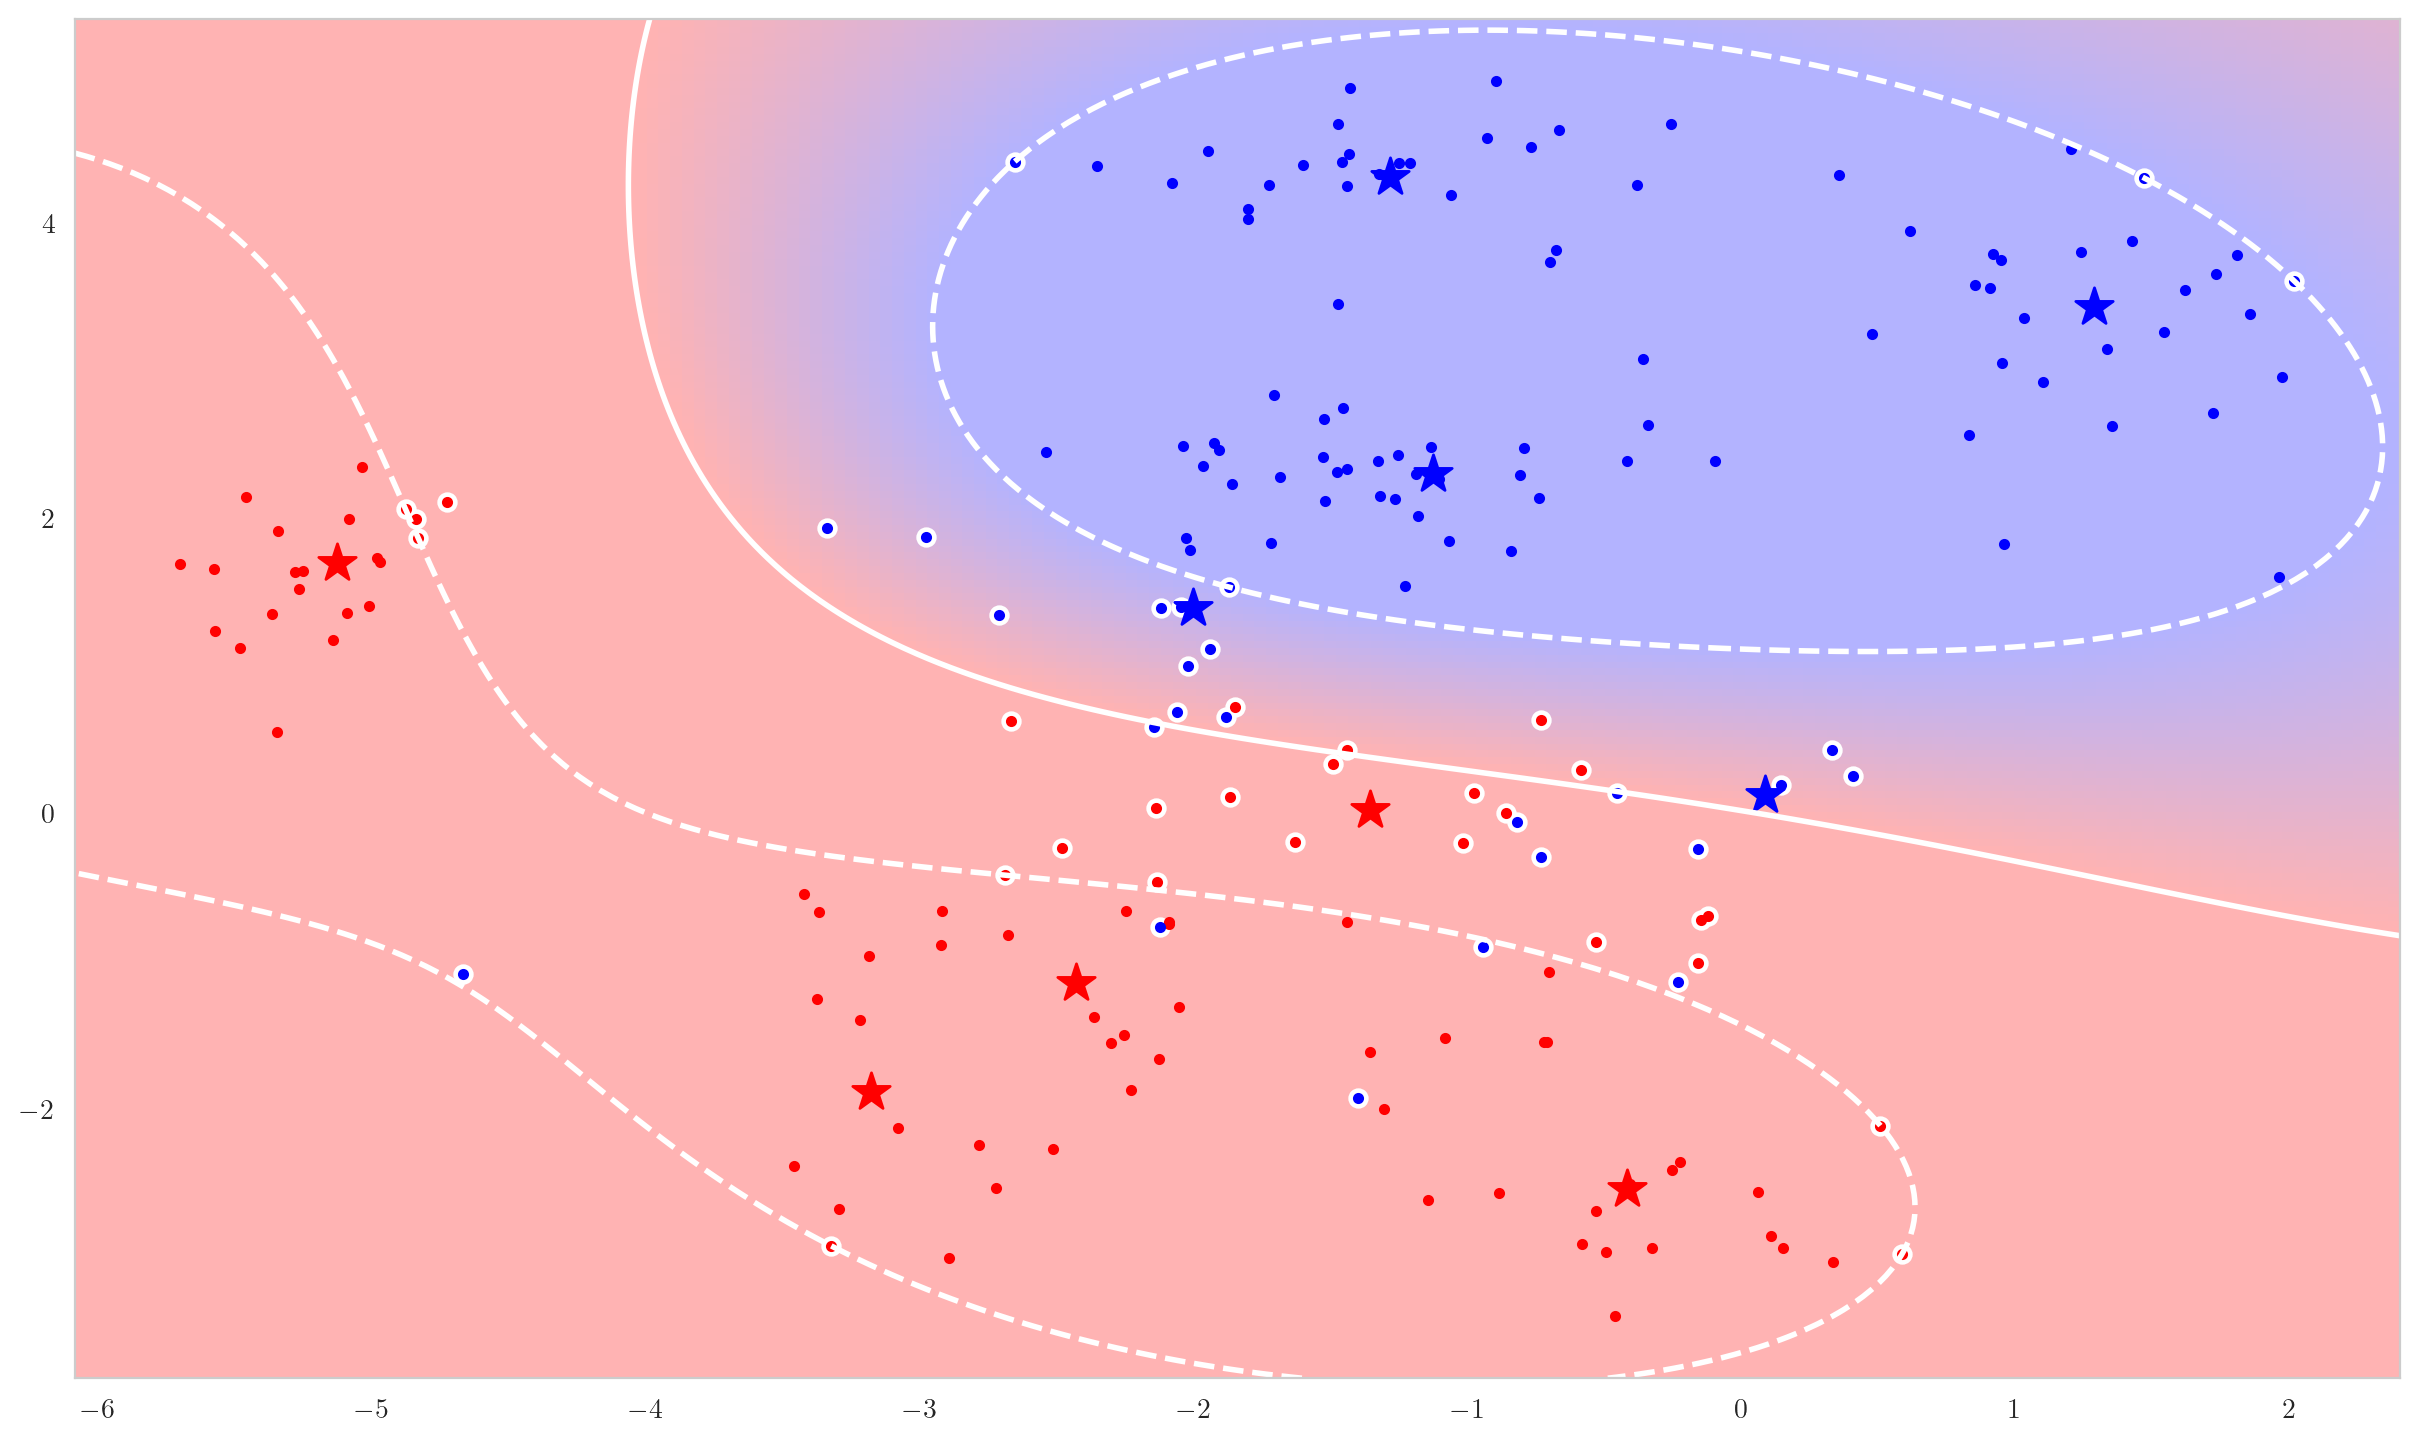

In [34]:
model_svm = SVC(kernel="rbf", C=1e0).fit(x, z)

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
print("%d опорных векторов" % model_svm.support_vectors_.shape[0])
ax.scatter( model_svm.support_vectors_[:, 0], model_svm.support_vectors_[:, 1], color='white', s=40 )
plot_points(ax, x, z, mu1=mus[0], mu2=mus[1])
plot_colormesh_svm(ax, model_svm)
plt.show()